# ORC
### Example 2: Forecasting the KS system
This notebook closely resembles Example 1, but instead of forecasting the Lorenz63 system (which is a low-dimensional, coupled ODE system), the task at hand is forecasting the Kuramoto Sivashinsky system, a 1D PDE. This illustrative example also exposes some of the more advanced functionality of the `ESNForecaster` model. In particular, a parallel reservoir scheme is demonstrated and many of the default hyperparameters of the model are overwritten. 

In [1]:
import jax
import jax.numpy as jnp

import orc

jax.config.update("jax_enable_x64", True)

# Generate KS data

Given a domain (`domain`), spatial discretization (`Nx`), temporal discretization (`dt`), and final time (`tN`), we integrate the KS system from a pseudorandom initial condition (`u0`). For our specified domain length, we estimate the largest Lyapunov exponent of the system to be 0.081 [1]. 

In [2]:
# integrate
lyap = 0.081
Nx = 128
tN = 1500
domain = (0, 48)
x0 = jnp.linspace(domain[0], domain[1], Nx, endpoint=True)  # Note: important to ensure PBC of IC. (however, the spectral solver throws away this point)
u0 = jnp.sin((3 / domain[1]) * jnp.pi * x0)
u0 = u0 + jax.random.normal(key=jax.random.key(3), shape=u0.shape)
dt = 0.25
U,t = orc.data.KS_1D(tN, u0=u0, dt=dt, domain=domain, Nx=Nx)

We visualize the data below using the built in `imshow_1D_spatiotemp` function.

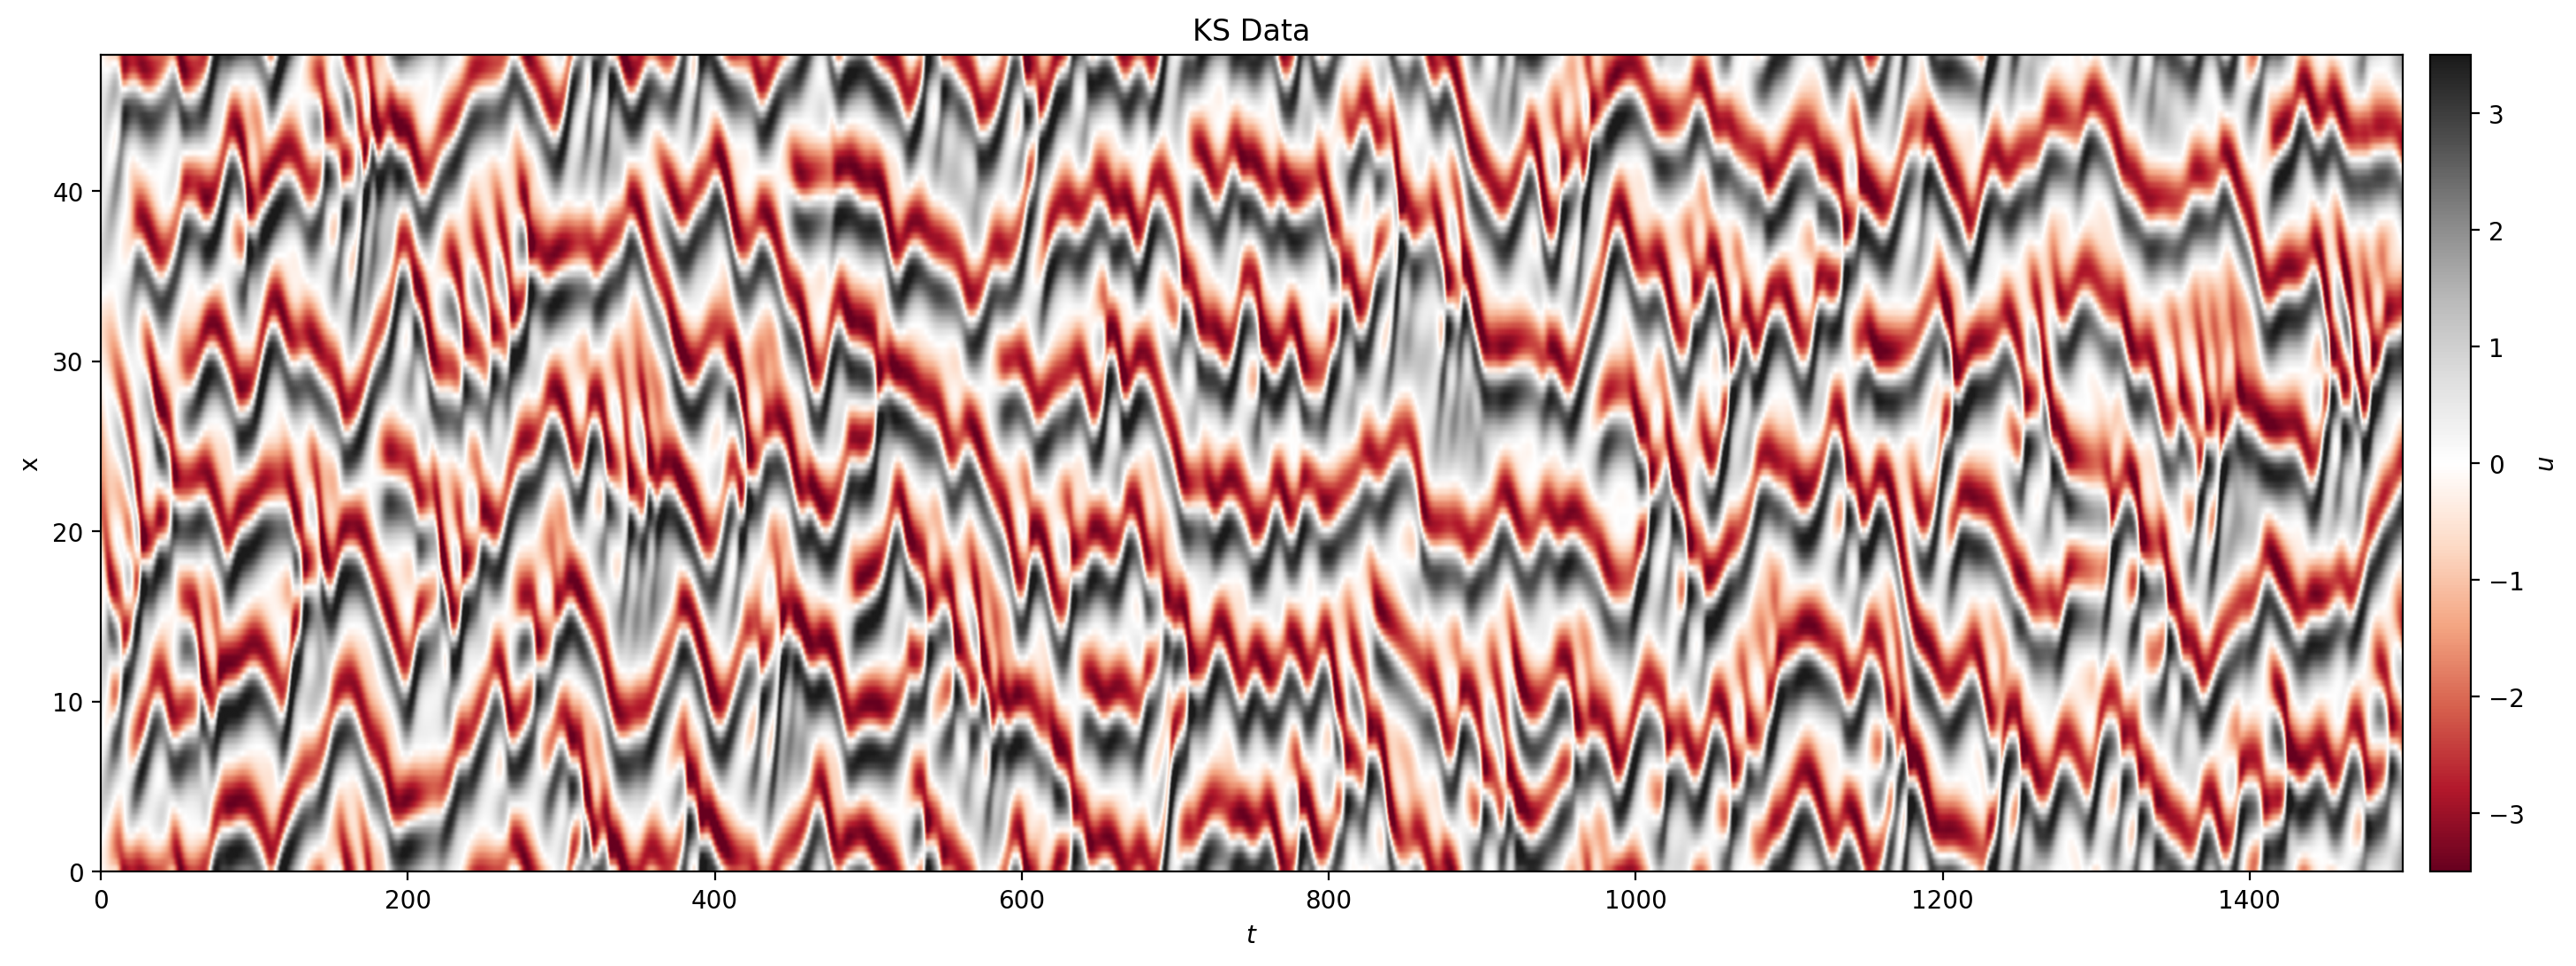

In [3]:
# visualize data
orc.utils.visualization.imshow_1D_spatiotemp(
    U,
    t[-1],
    domain,
    vmax=3.5,
    vmin=-3.5,
    title="KS Data",
    x_label= r"$t$",
)

As in the Lorenz example, we perform a train/test split. However, in this case we add $\approx 3 \%$ Gaussian noise to the training data because small levels of added noise during training have been shown to improve the forecasting ability of ESN models [2].

In [4]:
# train test split
test_perc = 0.2
split_index = int((1 - test_perc) * U.shape[0])
U_train = U[:split_index, :]
train_key = jax.random.key(3)
U_train += jax.random.normal(key=train_key, shape=U_train.shape) * jnp.std(U_train) * 0.03
U_test = U[split_index:, :]
t_train = t[:split_index]
t_test = t[split_index:] - t[split_index]

The work of Pathak et al. [3] demonstrated that RC based approaches for forecasting chaotic dynamics could be extended to high-dimensional cases through the use of a parallel reservoir architecture. Rather than training a single RC to forecast the entire field, the field is divided into "chunks" and individual ESNs are trained to forecast a single chunk. For the architecture to be effective, the input to each reservoir must include some overlap with adjacent chunks. This parameter is denoted as `locality`. 

In addition to providing a convenient interface for training parallel ESNs by setting the number of chunks > 1 in an `ESNForecaster`, the model also accepts other hyperparameter options as outlined in Platt et al. [4].

In [5]:
# esn parameters
res_dim = 1024 # number of reservoir neurons per chunk
chunks = 16  # number of chunks
locality = 8  # locality parameter for reservoir connections
beta = 1e-7

# init esn
esn = orc.models.ESNForecaster(
                                data_dim=Nx,
                                res_dim=res_dim,
                                seed=2,
                                chunks=chunks,
                                locality=locality,
                                leak_rate=0.534,
                                embedding_scaling=0.005,
                                bias=1.915,
                                Wr_spectral_radius=0.7,
                               )


The instantiated `ESNForecaster` is trained as in the Lorenz example.

In [6]:
esn, R = orc.models.train_ESNForecaster(
    esn,
    U_train,
    beta=beta
)

Forecasting with the parallel reservoir ESN is also performed exactly as in the single reservoir case.

In [7]:
U_fcast = esn.forecast(U_test.shape[0], R[-1])

We now plot the forecast of the trained ESN against Lyapunov time...

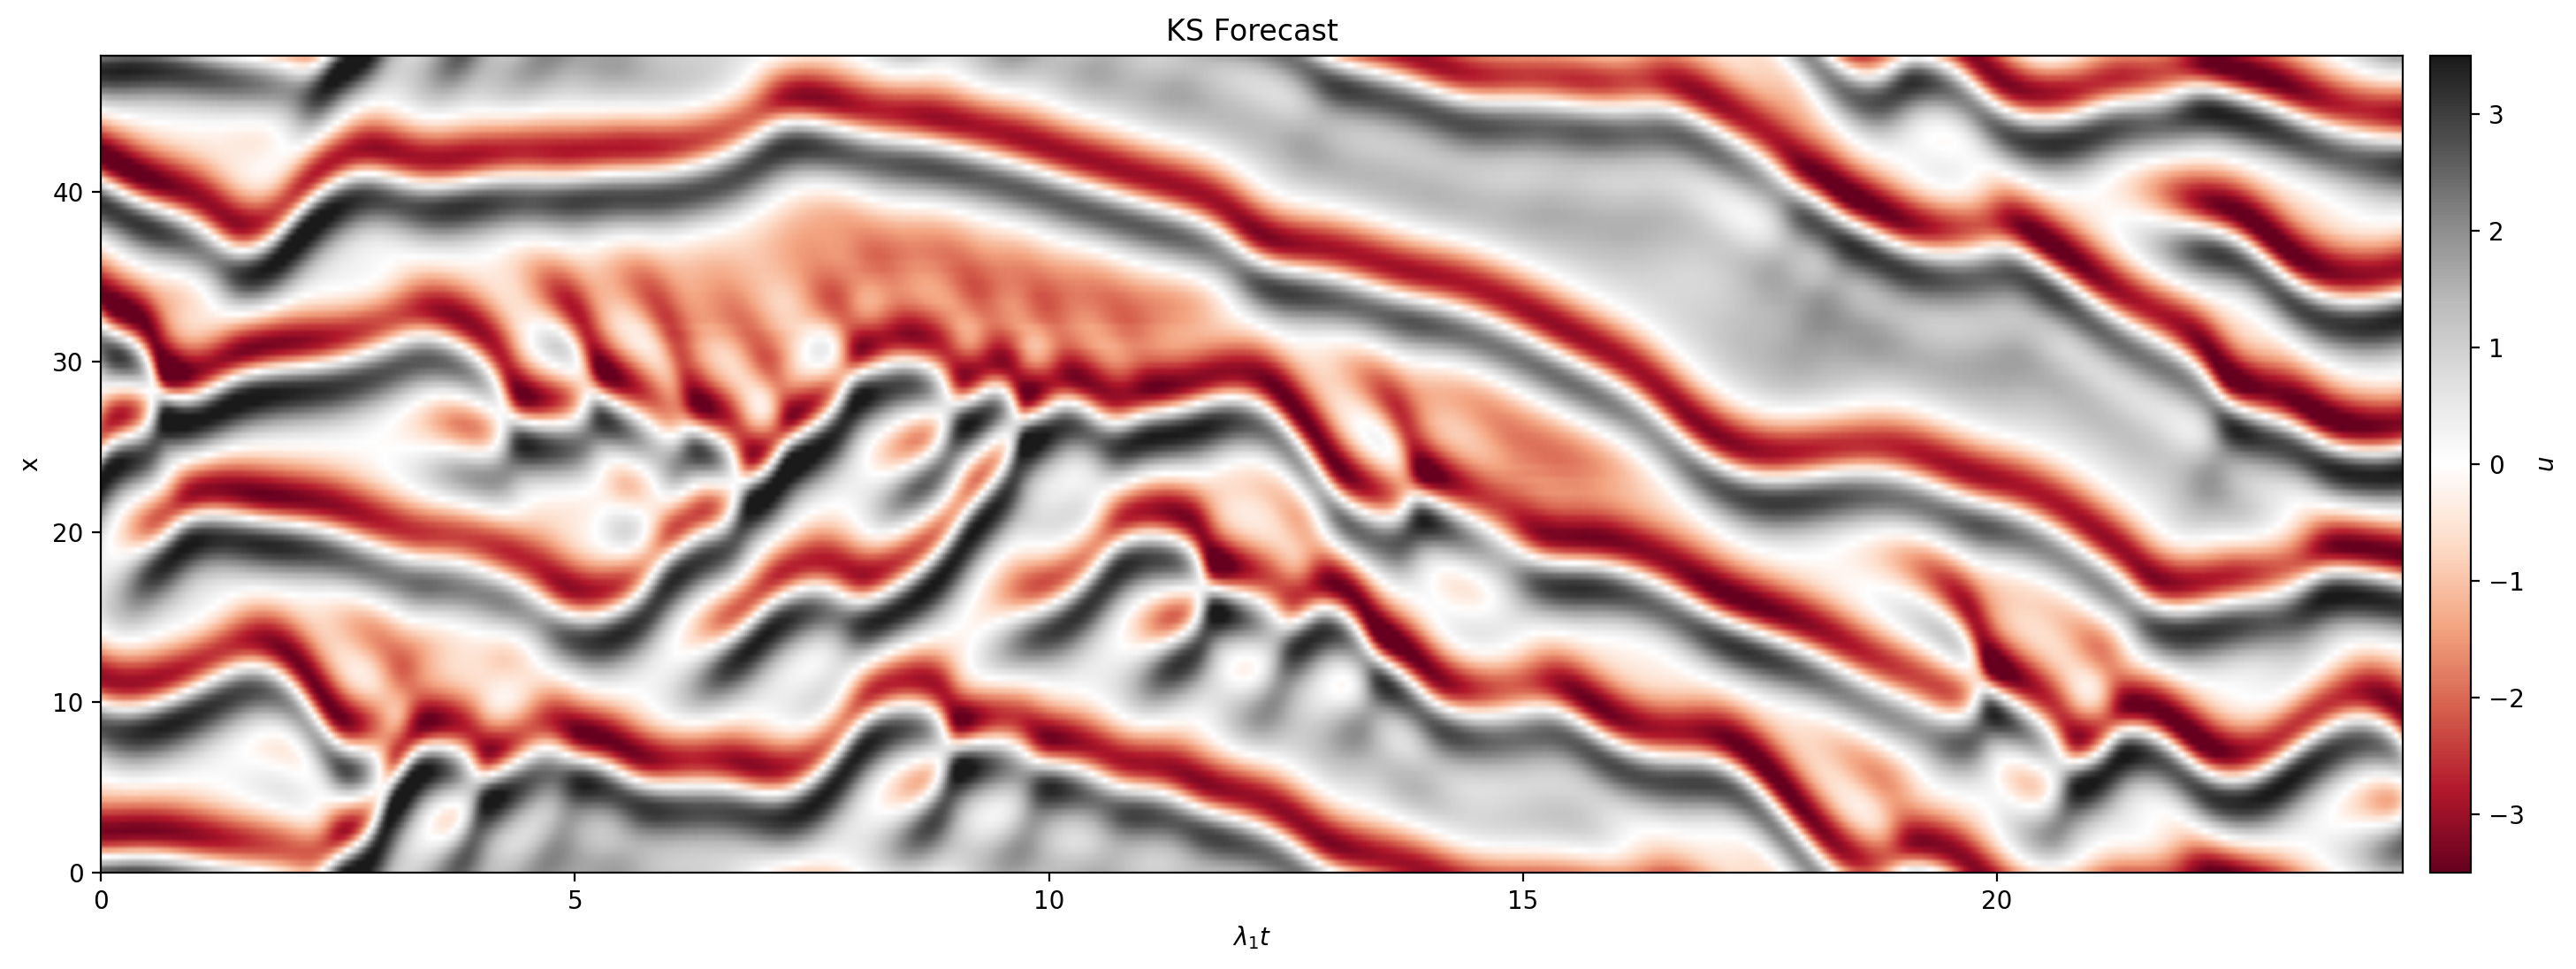

In [8]:
orc.utils.visualization.imshow_1D_spatiotemp(
    U_fcast,
    t_test[-1] * lyap,
    domain,
    vmax=3.5,
    vmin=-3.5,
    title="KS Forecast",
    x_label= r"$\lambda _1 t$"
)

... as well as the deviation from the ground truth test data.

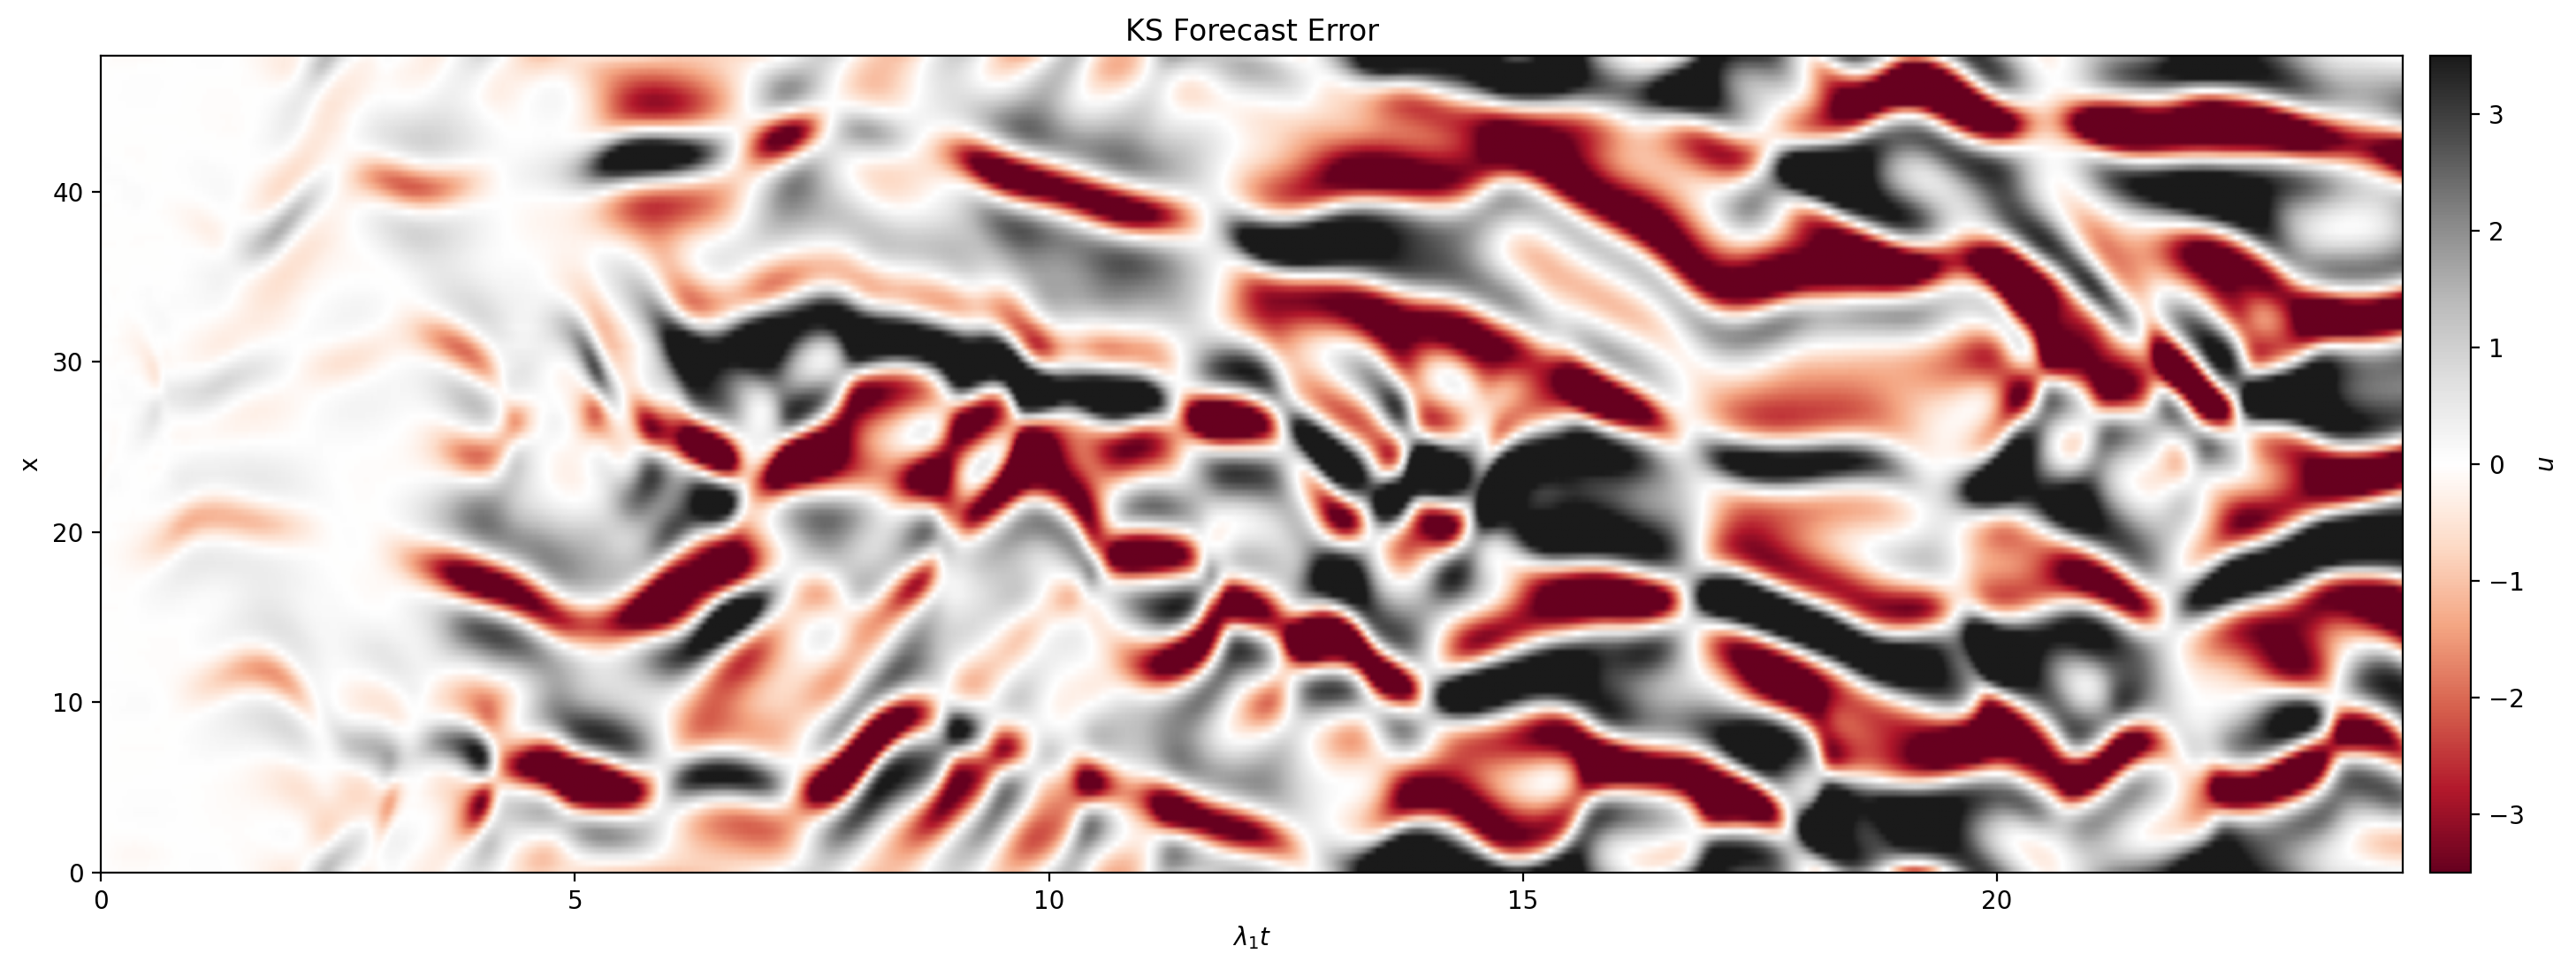

In [9]:
orc.utils.visualization.imshow_1D_spatiotemp(
    U_test - U_fcast,
    t_test[-1] * lyap,
    domain,
    vmax=3.5,
    vmin=-3.5,
    title="KS Forecast Error",
    x_label= r"$\lambda _1 t$"
)

Forecasting performance can be improved (at the cost of computation time) by increasing both the number of chunks and the reservoir dimensions.

### References
[1] Edson et al., "Lypaunov exponents of the Kuramoto Sivashinsky PDE," *The Anziam Journal*, 2019.

[2] Vlachas et al., "Backpropagation Algorithms and Reservoir Computing in Recurrent Neural Networks for the Forecasting of Complex Spatiotemporal Dynamics," *Neural Networks*, 2020.

[3] Pathak et al., "Model-Free Prediction of Large Spatiotemporally Chaotic Systems from Data: A Reservoir Computing Approach," *Physical Review Letters*, 2018.

[4] Platt et al., "A systematic exploration of reservoir computing for forecasting complex spatiotemporal dynamics," *Neural Networks*, 2022.